In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
inflation = np.linspace(1.0, 1.4, 5)

In [3]:
data_enkf = np.load("Data/Lorentz96/ek.npz")
data_mpf = np.load("Data/Lorentz96/mpf.npz")
data_pk_lr = np.load("Data/Lorentz96/pk_lr.npz")
data_pk_mr = np.load("Data/Lorentz96/pk_mr.npz")
data_pk_sr = np.load("Data/Lorentz96/pk_sr.npz")
data_ka_lr = np.load("Data/Lorentz96/ka_lr.npz")
data_ka_mr = np.load("Data/Lorentz96/ka_mr.npz")
data_ka_sr = np.load("Data/Lorentz96/ka_sr.npz")

In [4]:
def load_data(data):
    X = []
    for i in range(inflation.shape[0]):
        X.append(data[("arr_"+str(i))])
    return X

In [5]:
ek = load_data(data_enkf)
mpf = load_data(data_mpf)
pk_lr = load_data(data_pk_lr)
pk_mr = load_data(data_pk_mr)
pk_sr = load_data(data_pk_sr)
ka_lr = load_data(data_ka_lr)
ka_mr = load_data(data_ka_mr)
ka_sr = load_data(data_ka_sr)

In [6]:
def stats_computing_true(X):
    N = X.shape[-1]
    mu = np.mean(X, axis=2)
    X_c = X - mu[:,:,None]
    P = np.einsum('nim,njm->nij', X_c, X_c) / (N - 1) # 1+N_assi, d, d
    return mu, np.einsum('nkk->n', P)
def stats_computing(X):
    N = X.shape[-1]
    mu = np.mean(X, axis=3)
    X_c = X - mu[:,:,:,None]
    P = np.einsum('anim,anjm->anij', X_c, X_c) / (N - 1) # N_exp, 1+N_assi, d, d
    return mu, np.einsum('mnkk->mn', P)

In [7]:
def rout(X, threshold = 10):
    filtered = X[X < threshold]
    return filtered

In [21]:
def stats_data(X, mu_true, P_true, N_count = 20):
    mask = ~np.isnan(X).any(axis=(1,2,3))
    X_clean = X[mask]

    X_clean = X
    mu_X, P_X = stats_computing(X_clean) # N_exp, 1+N_assi
    mu_X_count = mu_X[:,N_count:,:]
    P_X_count = P_X[:,N_count:]
    mu_true_count = mu_true[N_count:, :]
    P_true_count = P_true[N_count:]
    error_mu = np.mean(np.sqrt(np.mean((mu_X_count - mu_true_count[None,:,:]) ** 2, axis = 2)), axis = 1)
    error_P = np.mean(np.abs(P_X_count - P_true_count[None,:]), axis = 1)

    R_mu = rout(error_mu)
    R_P = rout(error_P)
    return np.mean(R_mu), np.mean(R_P)

In [22]:
def organize_data(L, mu, P):
    e_mu = np.zeros(inflation.shape[0])
    e_P = np.zeros(inflation.shape[0])
    for i in range(inflation.shape[0]):
        a, b = stats_data(L[i], mu, P, N_count = 20)
        e_mu[i] = a
        e_P[i] = b
    return e_mu, e_P

In [23]:
def pointwise_min(vectors):
    stacked = np.vstack(vectors).astype(float)

    return np.min(stacked, axis=0)

In [24]:
X_true = np.load("Data/Lorentz96/pf.npy")

In [25]:
mu_t, P_t = stats_computing_true(X_true)

In [26]:
ek_sample = np.mean(ek[0][0,:,0,:], axis = 1)
ka_sample = np.mean(ka_lr[0][1,:,0,:], axis = 1)
ek_inf_sample = np.mean(ek[4][1,:,0,:], axis = 1)
ka_inf_sample = np.mean(ka_lr[2][0,:,0,:], axis = 1)

In [27]:
def plot_mu_vs_ek(
    mu_t,
    ek_sample,
    label,
    color = "#0072B2",
    t=None,
    save_path=None,
    title=None,
    ylabel=r"$x_1$"):
    mu_true = mu_t[:, 0] if mu_t.ndim == 2 else mu_t
    T = len(mu_true)

    if t is None:
        t = np.arange(T)

    fig, ax = plt.subplots(figsize=(14, 3))

    ax.plot(
        t, mu_true,
        color="black",
        linewidth=2.6,
        linestyle="-",
        label="Ground truth"
    )
    
    ax.plot(
        t, ek_sample,
        color=color,       
        linewidth=2.2,
        linestyle="--",
        label=label,
        marker = "o"
    )
        

    ax.set_xlabel("Assimilation step", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_title(title, fontsize=13)

    ax.grid(True, linestyle="--", alpha=0.35)
    ax.tick_params(labelsize=10)

    ax.legend(frameon=False, fontsize=9, handlelength=2)

    fig.tight_layout()

    if save_path is not None:
        fig.savefig(save_path, dpi=300, bbox_inches="tight")

    return fig, ax


(<Figure size 1400x300 with 1 Axes>,
 <Axes: xlabel='Assimilation step', ylabel='$x_1$'>)

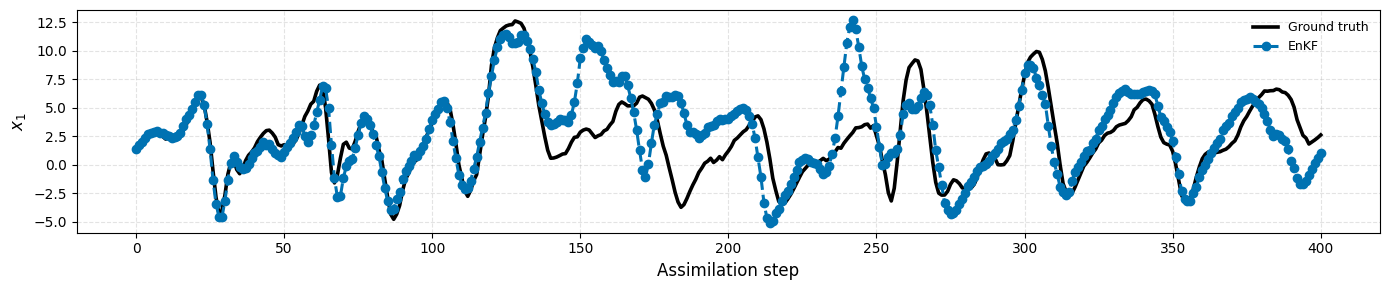

In [28]:
plot_mu_vs_ek(
    mu_t,
    ek_sample,          # shape (T, M)
    "EnKF",
    color = "#0072B2",
    save_path = "Plots/lorenz/lor96ek.png"
)

(<Figure size 1400x300 with 1 Axes>,
 <Axes: xlabel='Assimilation step', ylabel='$x_1$'>)

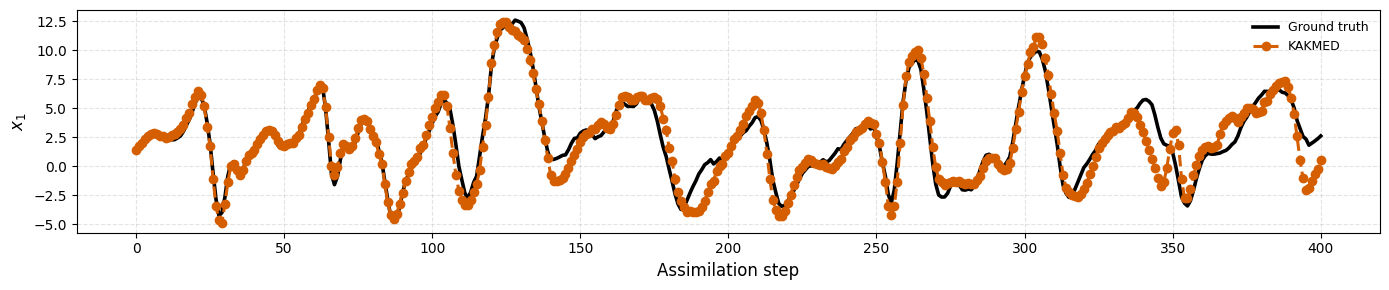

In [29]:
plot_mu_vs_ek(
    mu_t,
    ka_sample,   # shape (T, M)
    "KAKMED",
    color = "#D55E00",
    save_path = "Plots/lorenz/lor96ka.png"
)

(<Figure size 1400x300 with 1 Axes>,
 <Axes: xlabel='Assimilation step', ylabel='$x_1$'>)

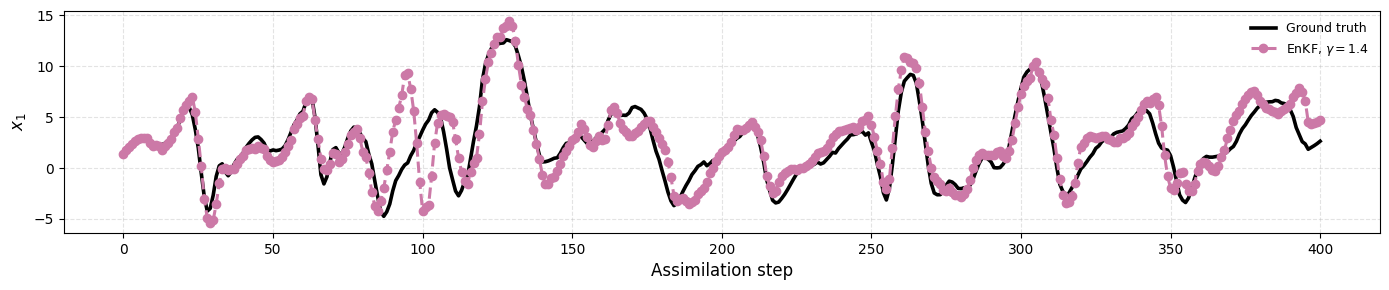

In [30]:
plot_mu_vs_ek(
    mu_t,
    ek_inf_sample,          # shape (T, M),
    r"EnKF, $\gamma = 1.4$",
    color = "#CC79A7",
    save_path = "Plots/lorenz/lor96ekinf.png"
)

(<Figure size 1400x300 with 1 Axes>,
 <Axes: xlabel='Assimilation step', ylabel='$x_1$'>)

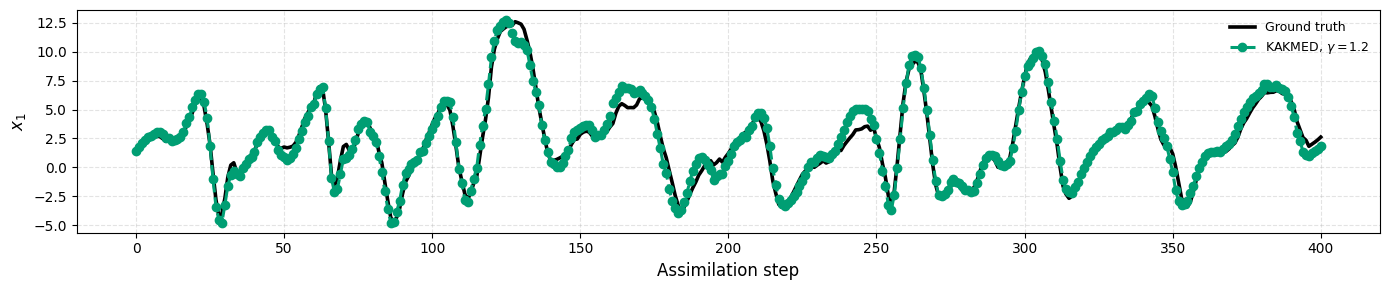

In [31]:
plot_mu_vs_ek(
    mu_t,
    ka_inf_sample,          # shape (T, M)
    r"KAKMED, $\gamma = 1.2$",
    color = "#009E73",
    save_path = "Plots/lorenz/lor96kainf.png"
)

In [32]:
e_mu_ek, e_P_ek = organize_data(ek, mu_t, P_t)
e_mu_mpf, e_P_mpf = organize_data(mpf, mu_t, P_t)

C:\Users\linfe\miniconda3\envs\torch_env\Lib\site-packages\numpy\_core\fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\linfe\miniconda3\envs\torch_env\Lib\site-packages\numpy\_core\_methods.py:144: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [33]:
e_mu_pk_lr, e_P_pk_lr = organize_data(pk_lr, mu_t, P_t)
e_mu_pk_mr, e_P_pk_mr = organize_data(pk_mr, mu_t, P_t)
e_mu_pk_sr, e_P_pk_sr = organize_data(pk_sr, mu_t, P_t)

In [34]:
e_mu_ka_lr, e_P_ka_lr = organize_data(ka_lr, mu_t, P_t)
e_mu_ka_mr, e_P_ka_mr = organize_data(ka_mr, mu_t, P_t)
e_mu_ka_sr, e_P_ka_sr = organize_data(ka_sr, mu_t, P_t)

In [35]:
# --- Global style settings (optional but recommended) ---
plt.rcParams.update({
    "font.size": 12,
    "font.family": "serif",
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "grid.linestyle": "--",
    "lines.linewidth": 2,
})

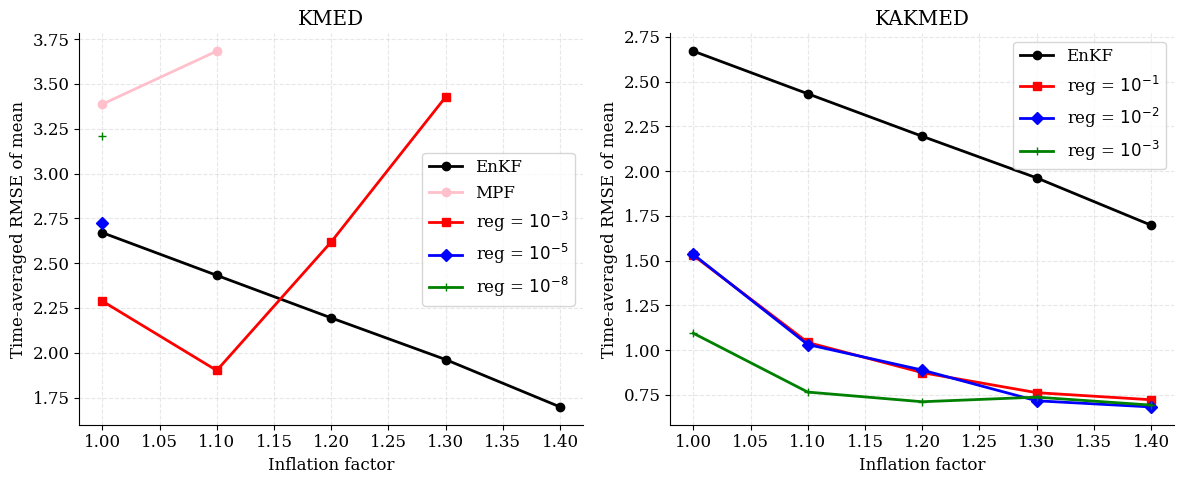

In [36]:
# --- Create figure with 3 subplots ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
 
# --- Subplot 1 ---
axs[0].plot(inflation, e_mu_ek, color = "black", label = "EnKF", marker = "o")
axs[0].plot(inflation, e_mu_mpf, color = "pink", label = "MPF", marker = "o")
axs[0].plot(inflation, e_mu_pk_lr, color = "red", label = "reg = $10^{-3}$", marker = "s")
axs[0].plot(inflation, e_mu_pk_mr, color = "blue", label = "reg = $10^{-5}$", marker = "D")
axs[0].plot(inflation, e_mu_pk_sr, color = "green", label = "reg = $10^{-8}$", marker = "+")
axs[0].set_ylabel("Time-averaged RMSE of mean")
axs[0].set_xlabel("Inflation factor")
axs[0].set_title("KMED")
axs[0].legend()
 
# --- Subplot 2 ---
axs[1].plot(inflation, e_mu_ek, color = "black", label = "EnKF", marker = "o")
axs[1].plot(inflation, e_mu_ka_lr, color = "red", label = "reg = $10^{-1}$", marker = "s")
axs[1].plot(inflation, e_mu_ka_mr, color = "blue", label = "reg = $10^{-2}$", marker = "D")
axs[1].plot(inflation, e_mu_ka_sr, color = "green", label = "reg = $10^{-3}$", marker = "+")
axs[1].set_ylabel("Time-averaged RMSE of mean")
axs[1].set_xlabel("Inflation factor")
axs[1].set_title("KAKMED")
axs[1].legend()

# --- Layout ---
fig.tight_layout()
plt.show()

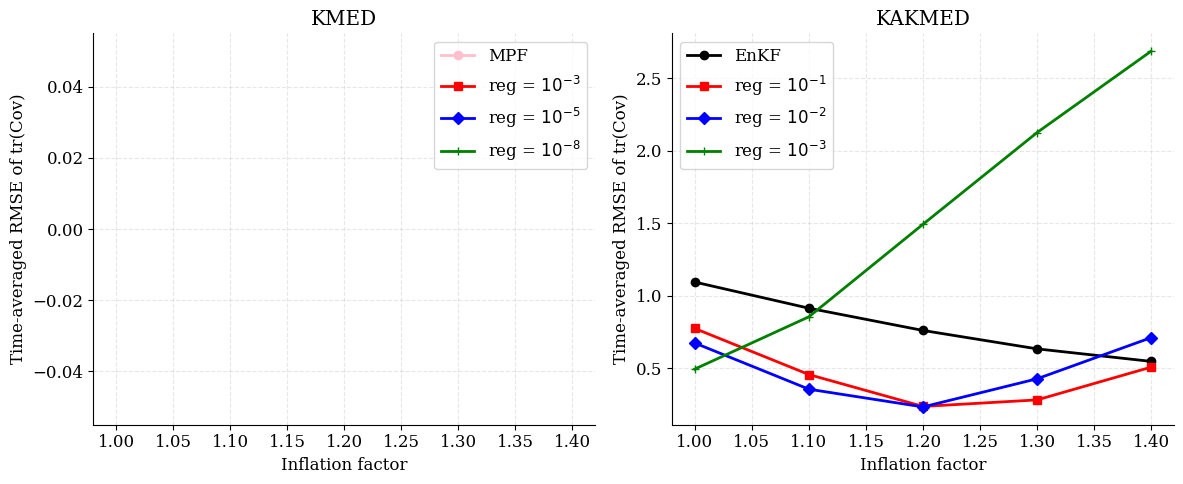

In [37]:
# --- Create figure with 3 subplots ---
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
 
# --- Subplot 1 ---
axs[0].plot(inflation, e_P_mpf, color = "pink", label = "MPF", marker = "o")
axs[0].plot(inflation, e_P_pk_lr, color = "red", label = "reg = $10^{-3}$", marker = "s")
axs[0].plot(inflation, e_P_pk_mr, color = "blue", label = "reg = $10^{-5}$", marker = "D")
axs[0].plot(inflation, e_P_pk_sr, color = "green", label = "reg = $10^{-8}$", marker = "+")
axs[0].set_ylabel("Time-averaged RMSE of tr(Cov)")
axs[0].set_xlabel("Inflation factor")
axs[0].set_title("KMED")
axs[0].legend()
 
# --- Subplot 2 ---
axs[1].plot(inflation, e_P_ek, color = "black", label = "EnKF", marker = "o")
axs[1].plot(inflation, e_P_ka_lr, color = "red", label = "reg = $10^{-1}$", marker = "s")
axs[1].plot(inflation, e_P_ka_mr, color = "blue", label = "reg = $10^{-2}$", marker = "D")
axs[1].plot(inflation, e_P_ka_sr, color = "green", label = "reg = $10^{-3}$", marker = "+")
axs[1].set_ylabel("Time-averaged RMSE of tr(Cov)")
axs[1].set_xlabel("Inflation factor")
axs[1].set_title("KAKMED")
axs[1].legend()

# --- Layout ---
fig.tight_layout()
plt.show()

In [38]:
e_mu_pk = pointwise_min([e_mu_pk_lr, e_mu_pk_mr, e_mu_pk_sr])
e_mu_ka = pointwise_min([e_mu_ka_lr, e_mu_ka_mr, e_mu_ka_sr])
e_P_pk = pointwise_min([e_P_pk_lr, e_P_pk_mr, e_P_pk_sr])
e_P_ka = pointwise_min([e_P_ka_lr, e_P_ka_mr, e_P_ka_sr])

In [39]:
data = np.zeros((4, e_mu_pk.shape[0]))
data[0,:] = e_mu_ek
data[1,:] = e_mu_pk
data[2,:] = e_mu_ka
data[3,:] = e_mu_mpf

col_names = [f"Inflation factor = {n}" for n in inflation]
# row labels you want
row_labels = ["EnKF", "KMED", "KAKMED", "MPF"]

df = pd.DataFrame(data, columns=col_names)
df.insert(0, " ", row_labels)   # first column as row labels
latex_code = df.to_latex(index=False)

print(latex_code)

\begin{tabular}{lrrrrr}
\toprule
  & Inflation factor = 1.0 & Inflation factor = 1.1 & Inflation factor = 1.2 & Inflation factor = 1.2999999999999998 & Inflation factor = 1.4 \\
\midrule
EnKF & 2.670223 & 2.432122 & 2.194582 & 1.962076 & 1.697786 \\
KMED & 2.288362 & NaN & NaN & NaN & NaN \\
KAKMED & 1.094310 & 0.765511 & 0.711578 & 0.716875 & 0.682543 \\
MPF & 3.387103 & 3.683217 & NaN & NaN & NaN \\
\bottomrule
\end{tabular}



In [40]:
data = np.zeros((4, e_P_pk.shape[0]))
data[0,:] = e_P_ek
data[1,:] = e_P_pk
data[2,:] = e_P_ka
data[3,:] = e_P_mpf

col_names = [f"Inflation factor = {n}" for n in inflation]
# row labels you want
row_labels = ["EnKF", "KMED", "KAKMED", "MPF"]

df = pd.DataFrame(data, columns=col_names)
df.insert(0, " ", row_labels)   # first column as row labels
latex_code = df.to_latex(index=False)

print(latex_code)

\begin{tabular}{lrrrrr}
\toprule
  & Inflation factor = 1.0 & Inflation factor = 1.1 & Inflation factor = 1.2 & Inflation factor = 1.2999999999999998 & Inflation factor = 1.4 \\
\midrule
EnKF & 1.093829 & 0.913639 & 0.760321 & 0.633424 & 0.547076 \\
KMED & NaN & NaN & NaN & NaN & NaN \\
KAKMED & 0.494341 & 0.355330 & 0.233146 & 0.281621 & 0.507614 \\
MPF & NaN & NaN & NaN & NaN & NaN \\
\bottomrule
\end{tabular}

